# Trade full matrix
**Full table was open in colab and cleaned cause it was 7GB**

### Table name:
Trade: Detailed trade matrix

Data was filtered for file to be smaller in: food_trading\00_read_full_trade_matrix_incolab.ipynb

### Metadata:

https://www.fao.org/faostat/en/#data/TM/metadata


# EDA

In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns

#save and load as parquet (for big files)
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
trade_mx = pd.read_csv(r"..\data\FAOSTAT\clean_data\food_trading\trade_matrix__imports_clean_codesOnly.csv")

In [3]:
trade_mx.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Unit,Value,Flag,import_export
0,3,3,828,2004,t,12.00,A,I
1,4,2,231,2005,t,3.00,A,I
2,3,3,56,2005,t,52.00,A,I
3,7,2,176,2022,t,25.06,A,I
4,4,2,711,1996,t,171.00,A,I


In [4]:
# There are RE-IMPORTS inside the same countries
trade_mx[trade_mx['Reporter Country Code'] == trade_mx['Partner Country Code']].head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Unit,Value,Flag,import_export
0,3,3,828,2004,t,12.0,A,I
2,3,3,56,2005,t,52.0,A,I
13,3,3,534,2004,t,1.0,A,I
12671,52,52,634,2008,t,0.0,A,I
15397,9,9,1274,1999,t,0.0,A,I


In [5]:
"""profile = ProfileReport(
    trade_mx.sample(1000000),
    title="FAOSTAT Trade Matrix Profile Report")

profile"""

'profile = ProfileReport(\n    trade_mx.sample(1000000),\n    title="FAOSTAT Trade Matrix Profile Report")\n\nprofile'

In [6]:
trade_mx.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Unit,Value,Flag,import_export
0,3,3,828,2004,t,12.00,A,I
1,4,2,231,2005,t,3.00,A,I
2,3,3,56,2005,t,52.00,A,I
3,7,2,176,2022,t,25.06,A,I
4,4,2,711,1996,t,171.00,A,I


<Axes: >

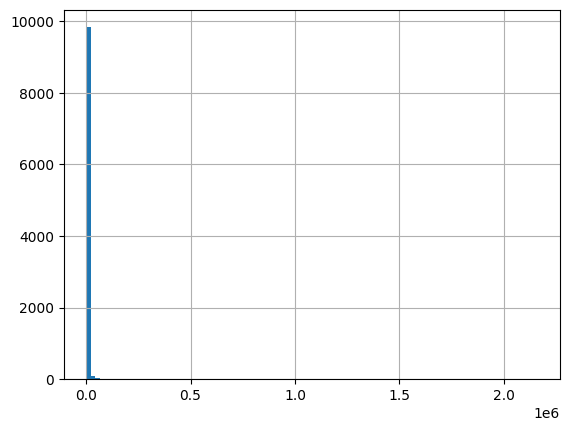

In [7]:
trade_mx['Value'].sample(10000).hist(bins=100)

<Axes: >

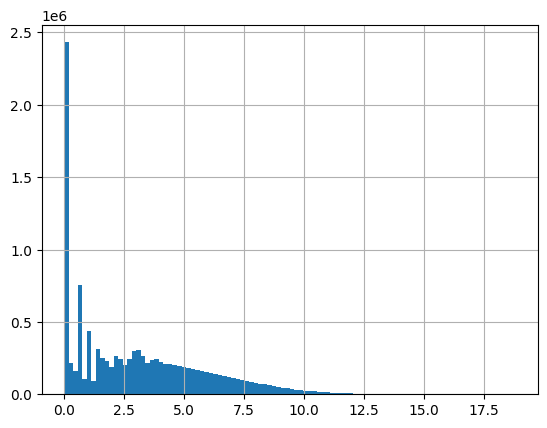

In [8]:
np.log(trade_mx['Value']+1).hist(bins=100)

# Clean up of ZERO trading value and really high values (trading value data is highly skewed)

In [9]:
trade_mx = trade_mx[trade_mx['Value'] > 0]

## Identify high traded products

In [10]:
items = pd.read_csv(r"..\data\FAOSTAT\clean_data\food_codes_categorized_final.csv", encoding="ISO-8859-1")

In [11]:
items.head()

,Item_Code,Item,conservation,diet,food_type
0,1002,Skins; karakul,Ambient,NaN,NaN
1,1007,Wool; shoddy,Ambient,NaN,NaN
2,1008,Hair; carded/combed,Ambient,NaN,NaN
3,1009,Wool; hair waste,Ambient,NaN,NaN
4,101,Canary seed,Ambient,vegan,grain


In [12]:
high_single_traded = trade_mx[trade_mx['Value'] > 1000000].sort_values(by='Value', ascending=False)

In [13]:
high_single_traded = high_single_traded.merge(items, left_on='Item Code', right_on='Item_Code', how = "left")

In [14]:
high_total_traded = trade_mx.groupby('Item Code')['Value'].sum().sort_values(ascending=False).to_frame()

In [15]:
high_total_traded.head()

,Value
Item Code,
1293,5.052681e+09
15,3.777502e+09
56,3.214921e+09
236,2.576860e+09
238,1.537302e+09


# drop not food items

There are some items that are not food like 1293 = "crude organic material"

I drop all these items from trade_mx

In [16]:
items_to_drop = items[items["food_type"].isnull()]

In [17]:
items_to_drop = items_to_drop['Item_Code'].tolist()

In [18]:
trade_mx[trade_mx['Item Code'] == 1293]

,Reporter Country Code,Partner Country Code,Item Code,Year,Unit,Value,Flag,import_export
137,4,2,1293,1997,t,4.0,A,I
142,4,2,1293,2000,t,2.0,A,I
152,4,2,1293,2001,t,10.0,A,I
154,4,2,1293,2002,t,17.0,A,I
163,4,2,1293,2003,t,4.0,A,I
...,...,...,...,...,...,...,...,...
11690487,150,181,1293,2009,t,6742.0,A,I
11690488,150,181,1293,2010,t,6036.0,A,I
11690489,150,181,1293,2011,t,4106.0,A,I
11690490,150,181,1293,2012,t,2818.0,A,I


In [19]:
trade_mx = trade_mx[~trade_mx['Item Code'].isin(items_to_drop)]

In [20]:
#Drop unnecesary columns
trade_mx = trade_mx.rename(columns={'Value': 'Value_tons'})
trade_mx.drop(columns=['Unit', 'import_export'], inplace=True)

In [21]:
trade_mx.head()

,Reporter Country Code,Partner Country Code,Item Code,Year,Value_tons,Flag
1,4,2,231,2005,3.00,A
2,3,3,56,2005,52.00,A
3,7,2,176,2022,25.06,A
4,4,2,711,1996,171.00,A
6,4,2,711,1997,160.00,A


In [22]:
trade_mx.to_parquet(r"..\data\FAOSTAT\clean_data\food_trading\trade_matrix__imports_clean_codesOnly_v2.parquet", index=False)